# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Luis Daniel Arellano Núñez

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://8c99a6c586f5:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 00:30:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Build schema
# Import your module
from Daniel_Arellano.sql_im import SparkUtils
from pyspark.sql.functions import get_json_object, col

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
schema_brands = SparkUtils.generate_schema([("brand_id", "int"), ("brand_info", "string")])
schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

base_path = "/opt/spark/work-dir/data/"
#Agencies
df_agencies = spark.read \
                .schema(schema_agencies) \
                .option("header", "true") \
                .csv(base_path + "car_service/agencies")
df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, "$.agency_name"))
df_agencies = df_agencies.withColumn("city", get_json_object(df_agencies.agency_info, "$.agency_name"))
df_agencies = df_agencies.drop("agency_info")
df_agencies.show(truncate=False)

#Brands
df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")
df_brands = df_brands.withColumn("brand_name", get_json_object(df_brands.brand_info, "$.brand_name"))
df_brands = df_brands.withColumn("country", get_json_object(df_brands.brand_info, "$.country"))
df_brands = df_brands.drop("brand_info")
df_brands.show(truncate=False)

#Cars
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")
df_cars = df_cars.withColumn("car_name", get_json_object(df_cars.car_info, "$.car_name"))
df_cars = df_cars.withColumn("brand_id", get_json_object(df_cars.car_info, "$.brand_id"))
df_cars = df_cars.withColumn("price_per_day", get_json_object(df_cars.car_info, "$.price_per_day"))
df_cars = df_cars.drop("car_info")
df_cars.show(truncate=False)

#Customers
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")
df_customers = df_customers.withColumn("customer_name", get_json_object(df_customers.customer_info, "$.customer_name"))
df_customers = df_customers.withColumn("city", get_json_object(df_customers.customer_info, "$.city"))
df_customers = df_customers.withColumn("age", get_json_object(df_customers.customer_info, "$.age"))
df_customers = df_customers.drop("customer_info")
df_customers.show(truncate=False)

#Rentals
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")
df_rentals = df_rentals.withColumn("car_id", get_json_object(df_rentals.rental_info, "$.car_id"))
df_rentals = df_rentals.withColumn("customer_id", get_json_object(df_rentals.rental_info, "$.customer_id"))
df_rentals = df_rentals.withColumn("agency_id", get_json_object(df_rentals.rental_info, "$.agency_id"))
df_rentals = df_rentals.drop("rental_info")
df_rentals.show(truncate=False)


+---------+-------------+-------------+
|agency_id|agency_name  |city         |
+---------+-------------+-------------+
|1        |NYC Rentals  |NYC Rentals  |
|2        |LA Car Rental|LA Car Rental|
|3        |Zapopan Auto |Zapopan Auto |
|4        |SF Cars      |SF Cars      |
|5        |Mexico Cars  |Mexico Cars  |
+---------+-------------+-------------+

+--------+-------------+-------+
|brand_id|brand_name   |country|
+--------+-------------+-------+
|1       |Mercedes-Benz|Germany|
|2       |BMW          |Germany|
|3       |Audi         |Germany|
|4       |Ford         |US     |
|5       |BYD          |China  |
|6       |Honda        |Japan  |
|7       |Toyota       |Japan  |
+--------+-------------+-------+

+------+------------------------------------+--------+-------------+
|car_id|car_name                            |brand_id|price_per_day|
+------+------------------------------------+--------+-------------+
|1     |Chang-Fisher Model 7                |5       |139          |

In [7]:
#left join
df_final = df_rentals
df_cars_2 = df_cars
df_customers_2 = df_customers
df_agencies_2 = df_agencies

result = df_final.join(
    df_cars_2.select("car_id", "car_name"),
    df_final["car_id"] == df_cars_2["car_id"],
    "left"
).select(
    df_final["*"],
    col("car_name")
)

result = result.join(
    df_agencies_2.select("agency_id", "agency_name"),
    result["agency_id"] == df_agencies_2["agency_id"],
    "left"
).select(
    result["*"],
    col("agency_name")
)

result = result.join(
    df_customers_2.select("customer_id", "customer_name"),
    result["customer_id"] == df_customers_2["customer_id"],
    "left"
).select(
    result["*"],
    col("customer_name")
)
result = result.drop("car_id", "customer_id", "agency_id")
result.show()


+---------+--------------------+-------------+---------------+
|rental_id|            car_name|  agency_name|  customer_name|
+---------+--------------------+-------------+---------------+
|    11891|Wallace-Carlson M...|  NYC Rentals| Margaret Jones|
|    11892|Grimes-Green Model 8|LA Car Rental|Albert Williams|
|    11893|Stewart-Allen Mod...|      SF Cars|  Caleb Fleming|
|    11894|  Campos PLC Model 4|  NYC Rentals|  Andrew Butler|
|    11895|  Wagner LLC Model 1|      SF Cars|  Kristin Potts|
|    11896|Jones, Jefferson ...|LA Car Rental|   Jeremy Parks|
|    11897|Lopez and Sons Mo...| Zapopan Auto|    Terry Wells|
|    11898| Salazar Ltd Model 8|      SF Cars|  Marc Williams|
|    11899|Villanueva PLC Mo...|LA Car Rental| Danny Williams|
|    11900|Faulkner-Howard M...|      SF Cars| Eric Owens PhD|
|    11901|Faulkner-Howard M...|  NYC Rentals|    Laura Perry|
|    11902|Faulkner-Howard M...|  NYC Rentals|     Paul Brown|
|    11903|Atkinson Ltd Mode...| Zapopan Auto|Alexa Her

[Stage 22:=============================>                            (1 + 1) / 2]

17834


# Persiste Data

## Parquet file

In [11]:
result.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")

In [17]:
!ls ../../data/car_service/output/parquet
!du -sh ../../data/car_service/output/parquet
!du -sh ../../data/car_service/rentals

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'
144K	../../data/car_service/output/parquet
1.2M	../../data/car_service/rentals


# CSV Files

In [20]:
result.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/csv")

result.write \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/rentals/csv")

result.write \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/rentals/parquet")

In [21]:
!du -sh ../../data/car_service/output/csv

856K	../../data/car_service/output/csv


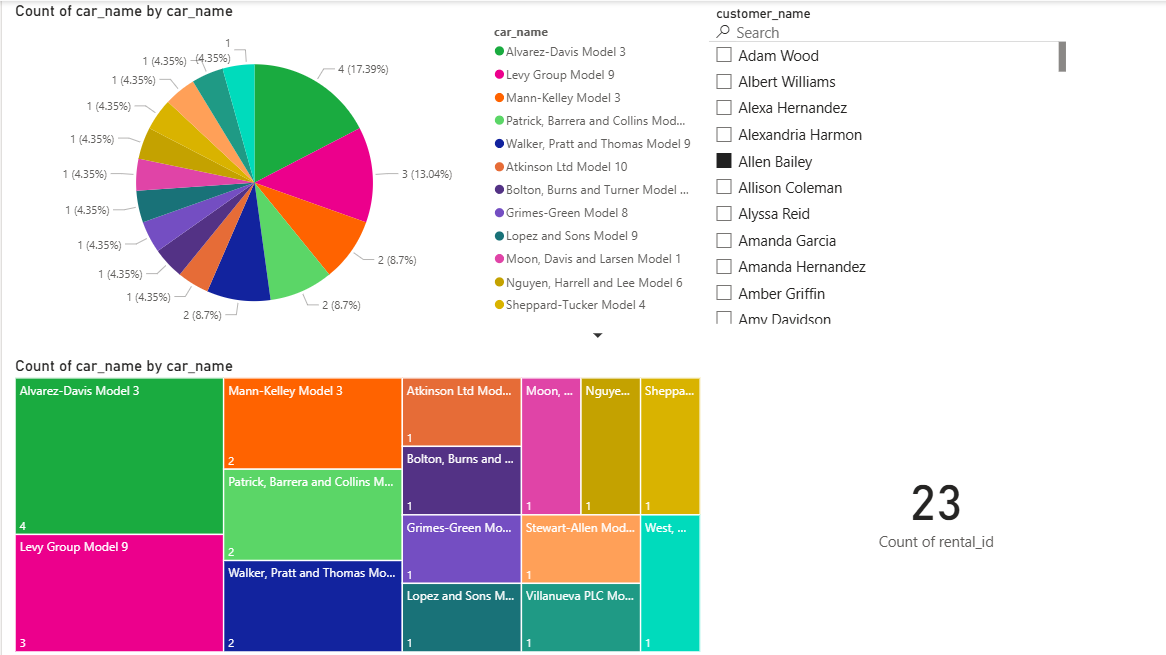

In [6]:
sc.stop()